# <font color='blue'>Setup

In [51]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [52]:
# Load the data
#house = pd.read_csv('./housing.csv',na_values=[],keep_default_na=False)
house = pd.read_csv('./housing.csv')
#print(house.head())
#print(house.dtypes)

# <font color='blue'>Part 1

In [53]:
# Perform any cleaning, feature engineering, and EDA you deem necessary.
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [54]:
before_shape = house.shape
# Be sure to remove any houses that are not residential from the dataset.
house = house[house['MSZoning'].isin(['RH', 'RL','RM'])]
print(before_shape[0] - house.shape[0], "non residential removed")

75 non residential removed


In [55]:
# The features below have some string "NA" values that have a meaning for the associated feature but they are being
# interpreted incorrectly as NaN by Pandas. Therefore subsitute some other string value to faciliate analysis.

house['LotFrontage'].fillna(0, inplace=True)
house['Alley'].fillna("NoAlleyAccess", inplace=True)
house['BsmtQual'].fillna("NoBasement", inplace=True)
house['BsmtCond'].fillna("NoBasement", inplace=True)
house['BsmtExposure'].fillna("NoBasement", inplace=True)
house['BsmtFinType1'].fillna("NoBasement", inplace=True)
house['BsmtFinType2'].fillna("NoBasement", inplace=True)
house['Electrical'].fillna("NoElectrical", inplace=True)
house['FireplaceQu'].fillna("NoFireplace", inplace=True)
house['GarageType'].fillna("NoGarage", inplace=True)
house['GarageYrBlt'].fillna(0, inplace=True)
house['GarageFinish'].fillna("NoGarage", inplace=True)
house['GarageQual'].fillna("NoGarage", inplace=True)
house['GarageCond'].fillna("NoGarage", inplace=True)
house['MasVnrType'].fillna("NotApplicable", inplace=True)
house['MasVnrArea'].fillna(0, inplace=True)
#house['PoolQC'].fillna("NoPool", inplace=True) # too few values that are not NA
house['Fence'].fillna("NoFence", inplace=True)
house['MiscFeature'].fillna("NoFeature", inplace=True)

# Check for any remaining null values
print("Features with Null values")
house_sum = house.isnull().sum()
for hs in house_sum.iteritems():
    if hs[1] > 0:
        print(hs)

Features with Null values
('PoolQC', 1378)


In [56]:
# Remove features that are not helpful
del house['Id']
del house['MoSold']
del house['MiscFeature'] # too few values
del house['MiscVal'] # too few values
del house['PoolQC'] # too few values
del house['PoolArea'] # too few values

In [57]:
# Make copy of a few features for use in Part 2 and Part 3
qual_area_orig = house[['OverallQual', 'TotalBsmtSF', 'GrLivArea']].copy()

In [58]:
# Create a list of potential non categorical features (integer or float)
non_cat_columns = []
for hd in house.dtypes.iteritems():
    if hd[1] != "object":
        non_cat_columns.append(hd[0])

# Remove categorical, year features and SalePrice because it's the target
non_cat_columns.remove('MSSubClass')
non_cat_columns.remove('YearBuilt')
non_cat_columns.remove('YearRemodAdd')
non_cat_columns.remove('GarageYrBlt')
non_cat_columns.remove('YrSold') # this is the feature that caused sklearn to throw an error, see comment below
non_cat_columns.remove('SalePrice')
print("Non categorical features\n", non_cat_columns)
#print("\nNon categorical features dtypes\n", house[non_cat_columns].dtypes)

# Standardise values of non categorical data
# Note I originally included the years in the standardisation but I got an error when I tried to run the
# logistic regressions even though I was not using any year feature as a predictor (weird sklearn bug?)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

#print(house[non_cat_columns].head(2))
house[non_cat_columns] = ss.fit_transform(house[non_cat_columns])
#print(house[non_cat_columns].head(2)) # check that it worked

Non categorical features
 ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']


In [59]:
# Convert categorical variable into dummy/indicator variables
house_with_ind = pd.get_dummies(house, drop_first=True)
corr = house_with_ind.corr()

# Only look at the correlation values related to SalePrice
print('Top Absolute Correlations\n')
top_corr = corr.SalePrice.abs().sort_values(ascending=False)[1:21]
print(top_corr)

print('\nTop Negative Correlations\n')
top_corr_neg = corr.SalePrice.sort_values(ascending=True)
for tcg in top_corr_neg.iteritems():
    if tcg[1] <= -0.20:
        print(tcg[0], tcg[1])

Top Absolute Correlations

OverallQual                0.790986
GrLivArea                  0.708499
GarageCars                 0.640954
GarageArea                 0.629048
TotalBsmtSF                0.617536
1stFlrSF                   0.617059
ExterQual_TA               0.599829
FullBath                   0.557077
TotRmsAbvGrd               0.536250
KitchenQual_TA             0.520466
YearBuilt                  0.517466
MasVnrArea                 0.508017
YearRemodAdd               0.499208
Foundation_PConc           0.493969
FireplaceQu_NoFireplace    0.475120
Fireplaces                 0.471702
ExterQual_Gd               0.455727
BsmtQual_TA                0.444230
BsmtFinType1_GLQ           0.436846
Neighborhood_NridgHt       0.413509
Name: SalePrice, dtype: float64

Top Negative Correlations

ExterQual_TA -0.599829286366
KitchenQual_TA -0.520465582057
FireplaceQu_NoFireplace -0.475120468478
BsmtQual_TA -0.44423042145
GarageFinish_Unf -0.408513985716
MasVnrType_None -0.38146219433
Ga

In [60]:
# Look at categorical data separately (set threshold lower as 0.5 doesn't show any)
print('Potential Absolute Correlations from Categorical Features\n')
top_corr = corr.SalePrice.abs().sort_values(ascending=False)
for tac in top_corr.iteritems():
    if ('_' in tac[0]) and tac[1] >= 0.3:
        print(tac[0], tac[1])

Potential Absolute Correlations from Categorical Features

ExterQual_TA 0.599829286366
KitchenQual_TA 0.520465582057
Foundation_PConc 0.493968659392
FireplaceQu_NoFireplace 0.475120468478
ExterQual_Gd 0.455726831217
BsmtQual_TA 0.44423042145
BsmtFinType1_GLQ 0.436845903385
Neighborhood_NridgHt 0.413508706472
GarageFinish_Unf 0.408513985716
MasVnrType_None 0.38146219433
SaleType_New 0.36714550238
SaleCondition_Partial 0.360553326855
GarageType_Detchd 0.349189095994
Neighborhood_NoRidge 0.339269514603
Foundation_CBlock 0.334813366227
FireplaceQu_Gd 0.334658704789
MasVnrType_Stone 0.330116540997
GarageType_Attchd 0.324889059177
KitchenQual_Gd 0.320223168251
BsmtExposure_Gd 0.31776111549
MSZoning_RL 0.301775015215
HeatingQC_TA 0.30079913174


In [61]:
# Choose potential predictors based on fixed characteristics
# 1. GrLivArea, 2. GarageCars, 3. GarageArea, 4. TotalBsmtSF, 5. 1stFlrSF 6. FullBath 7. YearBuilt 8. YearRemodAdd

corr = house.corr()
# GarageCars and GarageArea are strongly correlated so be careful of using both
print(corr.GarageCars.GarageArea)

0.885185021565


In [62]:
# Build a list of features to use with Recursive Feature Elimination
top_corr = corr.SalePrice.abs().sort_values(ascending=False)[1:21]
top_corr_features = []
for tc in top_corr.iteritems():
    top_corr_features.append(tc[0])

## <font color='blue'>Chosen list of potential 'renovate-able' predictors for the model

In [63]:
# Potential predictors that are renovate-able (for use in Part 2)
# 1. OverallQual 2. ExterQual 3. KitchenQual 4. GarageFinish 5. FireplaceQu 6. BsmtFinType1 7. HeatingQC

## <font color='blue'>Convert BsmtQual from categorical to continuous

In [64]:
# Based on the top ranked correlations for categorical features convert basement categorical data into
# ordinal values. Although categorical it is continuous in the sense that is on a scale from best to worst
house.BsmtQual = house.BsmtQual.map(lambda x: 6 if x == "Ex" else 5 if x == "Gd" else 4 if x == "TA" 
                                    else 3 if x == "Fa" else 2 if x == "Po" else 1)

In [65]:
# Make copy for use in Part 2 and Part 3
house_orig = house.copy()

In [66]:
# After fixing BsmtQual have another look
corr = house.corr()
print(corr.SalePrice.BsmtQual)

0.581983675165


## <font color='blue'>Chosen list of potential 'fixed' predictors for the model

In [67]:
# Original list of potentials
# 1. GrLivArea, 2. GarageCars, 3. GarageArea, 4. TotalBsmtSF, 5. 1stFlrSF 6. FullBath 7. YearBuilt 8. YearRemodAdd

# BsmtQual is moderately correlated so add it in
# 1. GrLivArea, 2. GarageCars, 3. GarageArea, 4. TotalBsmtSF, 5. 1stFlrSF 6. BsmtQual 7. FullBath 8. YearBuilt 9. YearRemodAdd

### <font color='blue'>Heatmap code below not particularly useful so it is commented out

In [68]:
# Have a look at the heatmap to check if any of the chosen 'fixed' features are correlated
#fig, ax = plt.subplots(figsize=(13,11))

#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

#ax = sns.heatmap(corr, mask=mask, ax=ax)

#ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
#ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

#plt.show()

In [69]:
print("Categorical types still left, ignore!\n")
for hd in house.dtypes.iteritems():
    if hd[1] == "object":
        print(hd)

Categorical types still left, ignore!

('MSZoning', dtype('O'))
('Street', dtype('O'))
('Alley', dtype('O'))
('LotShape', dtype('O'))
('LandContour', dtype('O'))
('Utilities', dtype('O'))
('LotConfig', dtype('O'))
('LandSlope', dtype('O'))
('Neighborhood', dtype('O'))
('Condition1', dtype('O'))
('Condition2', dtype('O'))
('BldgType', dtype('O'))
('HouseStyle', dtype('O'))
('RoofStyle', dtype('O'))
('RoofMatl', dtype('O'))
('Exterior1st', dtype('O'))
('Exterior2nd', dtype('O'))
('MasVnrType', dtype('O'))
('ExterQual', dtype('O'))
('ExterCond', dtype('O'))
('Foundation', dtype('O'))
('BsmtCond', dtype('O'))
('BsmtExposure', dtype('O'))
('BsmtFinType1', dtype('O'))
('BsmtFinType2', dtype('O'))
('Heating', dtype('O'))
('HeatingQC', dtype('O'))
('CentralAir', dtype('O'))
('Electrical', dtype('O'))
('KitchenQual', dtype('O'))
('Functional', dtype('O'))
('FireplaceQu', dtype('O'))
('GarageType', dtype('O'))
('GarageFinish', dtype('O'))
('GarageQual', dtype('O'))
('GarageCond', dtype('O'))
('P

In [70]:
print(top_corr_features)
# remove 'OverallQual' as it's not a fixed feature
top_corr_features.remove('OverallQual')

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'MasVnrArea', 'YearRemodAdd', 'Fireplaces', 'BsmtFinSF1', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'LotArea', 'GarageYrBlt', 'BsmtFullBath']


In [71]:
# Recursive Feature Elimination - does not produce a good result (uncomment to use)

# Choose features as the predictor values
#X = house_with_ind[top_corr_features]
#y = house_with_ind.SalePrice.values

# Recursive Feature Elimination (RFE)
#from sklearn.feature_selection import RFECV
#from sklearn.linear_model import LogisticRegression

# Note takes a few minutes to run
#lr = LogisticRegression()
#selector = RFECV(lr, step=1, cv=5, verbose=False)
#selector = selector.fit(X, y)

#print(selector.support_)
#print(selector.ranking_)

# Select the features based on the Recursive Feature Elimination
#features_selected = [top_corr_features[i] for i in range(len(top_corr_features)) if selector.support_[i]]
#print(features_selected)

In [72]:
# with cv=5 ['GarageCars', 'GarageArea', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', '2ndFlrSF', 'HalfBath']
# compare to just choosing based on highest correlation values
# 1. GrLivArea, 2. GarageCars, 3. GarageArea, 4. TotalBsmtSF, 5. 1stFlrSF 6. BsmtQual 7. FullBath 8. YearBuilt 9. YearRemodAdd

### <font color='blue'>Write a function that will do each regression based on the features given

In [73]:
# Put in a function so the code can be reused with different house features
def run_linear_regression(house_features, target='SalePrice'):
    print("Linear regression results for", house_features)
    
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    fig_size_default = fig_size
    # Set figure width to 6 and height to 4
    fig_size = [6, 4]
    plt.rcParams["figure.figsize"] = fig_size

    # Train a model on pre-2010 data and evaluate its performance on the 2010 houses
    X_train = house[house['YrSold'] < 2010]
    y_train = X_train[target]
    X_train = X_train[house_features]

    X_test = house[house['YrSold'] >= 2010]
    y_test = X_test[target]
    X_test = X_test[house_features]

    # Just to verify that the split has worked
    print("Train and test set sizes", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    slr = LinearRegression()
    slr.fit(X_train, y_train)
    predictions_test = slr.predict(X_test)
    plt.scatter(y_test, predictions_test)
    plt.title("Test predictions vs true values")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()
    
    print("Test slr scores", slr.score(X_test, y_test))
    print("Train slr scores", slr.score(X_train, y_train))
    print("\nLinear regression coefficients", slr.coef_)

    #print("\nLinear regression coefficients")
    #for value1, value2 in zip(house_features, slr.coef_):
    #    print("A 1 unit increase in", value1, "results in a", value2, "increase in the estimate of SalePrice")
    # A 1 unit increase in the selected features corresponds to a (x) unit increase in the estimate of SalePrice

    from sklearn.cross_validation import cross_val_score, cross_val_predict
    from sklearn import metrics

    # Perform 5-fold cross validation
    X = house[house_features]
    predictions = cross_val_predict(slr, X, y, cv=5)
    
    #plt.scatter(y, predictions)
    #plt.title("Cross validated predictions vs true values")
    #plt.xlabel("True Values")
    #plt.ylabel("Predictions")
    #plt.show()
    
    scores = cross_val_score(slr, X, y, cv=5)
    print("\nCross-validated scores:", scores)

    # manually calculate the r2
    r2 = metrics.r2_score(y, predictions)
    print("Cross-Predicted R2:", r2)
    
    # Plot the residuals
    predictions_train = slr.predict(X_train)
    plt.scatter(predictions_train, predictions_train-y_train, c='b')
    plt.scatter(predictions_test, predictions_test-y_test, c='g')
    plt.hlines(y=0, xmin=-50000, xmax=600000)
    plt.title("Residual plot with training (blue) and test (green) data")
    plt.ylabel("Residuals")

    plt.show()
    plt.rcParams["figure.figsize"] = fig_size_default
    
    return predictions_test, y_test

### <font color='blue'>Define 'SalePrice' as the target

In [74]:
# define our y (target)
y = house.SalePrice

### <font color='blue'>Cross predicted R2 shows a reasonable model using only the top 2 'fixed' predictor features

Linear regression results for ['GrLivArea', 'GarageCars']
Train and test set sizes (1221, 2) (1221,) (164, 2) (164,)


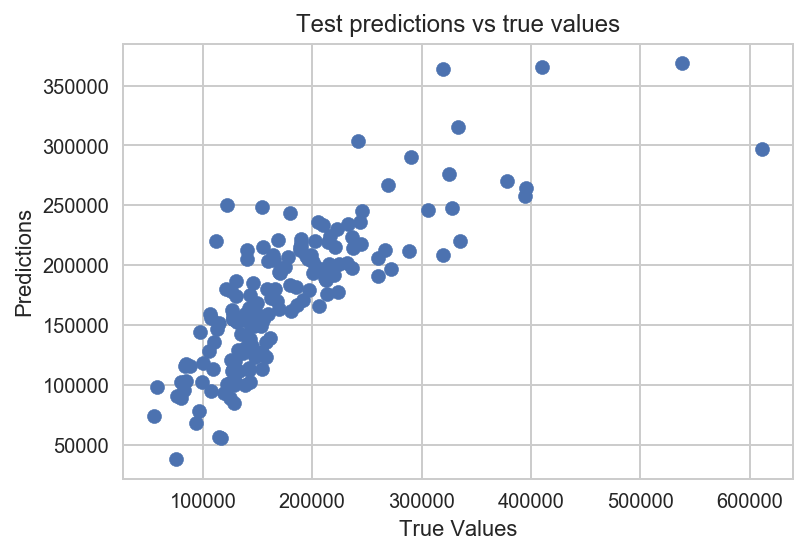

Test slr scores 0.633392527155
Train slr scores 0.6222100025

Linear regression coefficients [ 41403.30753217  31297.06212887]

Cross-validated scores: [ 0.70406169  0.63241902  0.63825808  0.60777803  0.50628981]
Cross-Predicted R2: 0.617964911939


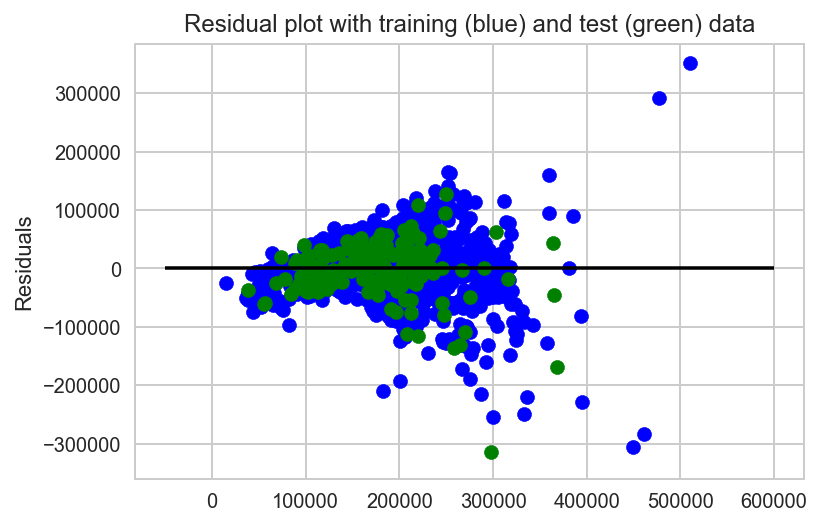

In [75]:
# First try the 2 highest 'fixed' correlations, try GarageCars and GarageArea and choose the best
# Plot the variable against the target to confirm the relationship visually
house_features = ['GrLivArea', 'GarageCars']
predictions_test, y_test = run_linear_regression(house_features)

### <font color='blue'>Cross predicted R2 goes up with the addition of 2 'fixed' predictor features

Linear regression results for ['GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']
Train and test set sizes (1221, 4) (1221,) (164, 4) (164,)


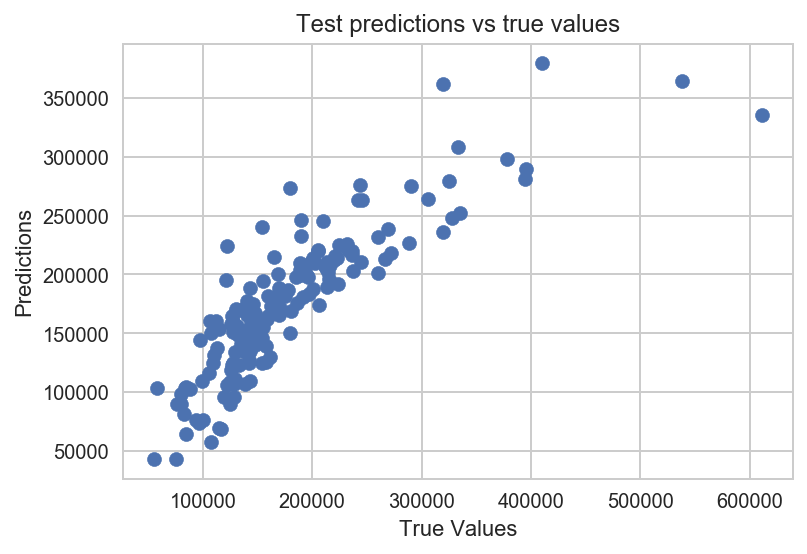

Test slr scores 0.729083903661
Train slr scores 0.673373845858

Linear regression coefficients [ 34736.013701    25311.43136687  21965.81586122  -1322.28557748]

Cross-validated scores: [-0.02303926  0.00707937  0.00116376 -0.00215289  0.00954177]
Cross-Predicted R2: 0.000676061785091


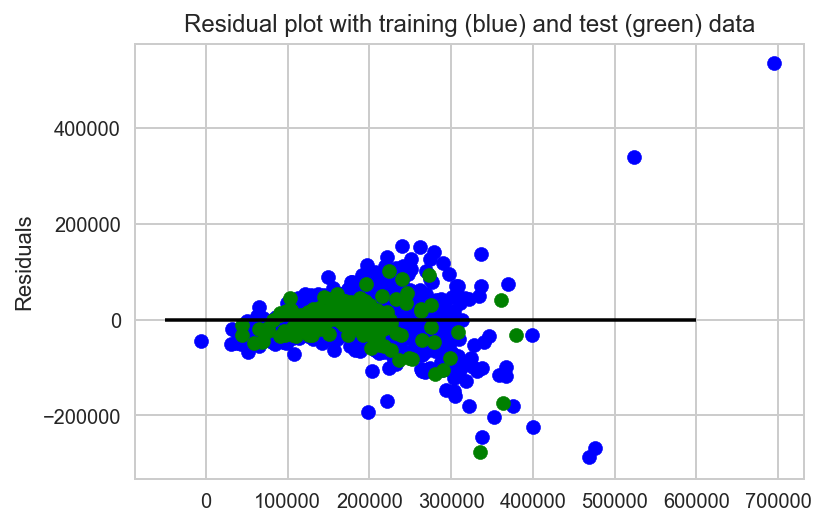

In [50]:
# Now add the next 2 highest 'fixed' correlations
house_features = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']
predictions_test, y_test = run_linear_regression(house_features)

### <font color='blue'>Cross predicted R2 goes up again when using 7 of the 8 potential 'fixed' predictor features
### <font color='blue'>This is the final model for 'fixed' predictor features

Linear regression results for ['GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'YearBuilt', 'YearRemodAdd']
Train and test set sizes (1221, 7) (1221,) (164, 7) (164,)


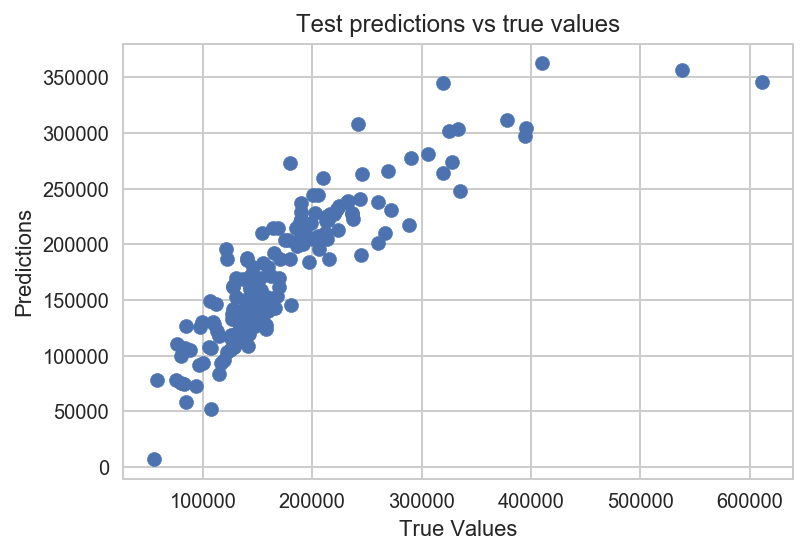

Test slr scores 0.760061145598
Train slr scores 0.732391591992

Linear regression coefficients [ 32681.31960668  14742.19280647   3615.36979857  10469.14532417
  16556.94772897    279.98244465    396.6142196 ]

Cross-validated scores: [ 0.78599899  0.74434848  0.75734594  0.7456054   0.56326611]
Cross-Predicted R2: 0.720165270772


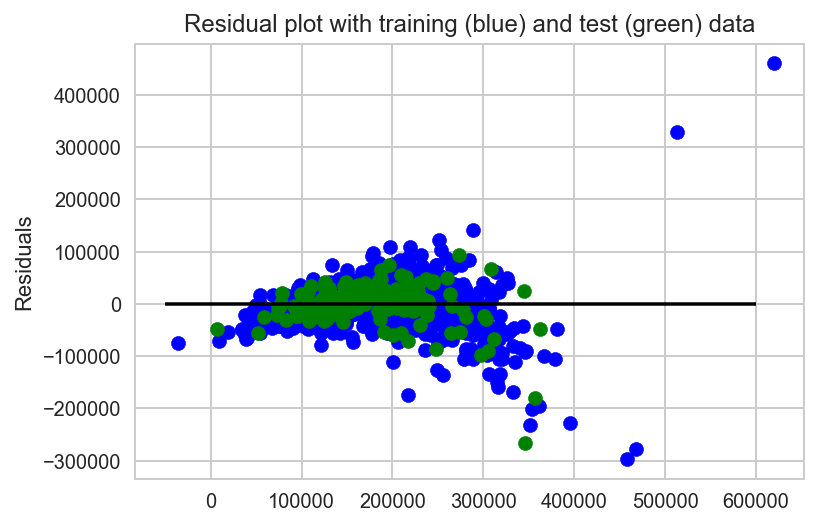

In [77]:
# Now find if there's any more from the other 4 unused worth adding
# 5. BsmtQual 6. FullBath 7. YearBuilt 8. YearRemodAdd
# Including 'FullBath' actually gives a very slightly worse result so remove it

house_features = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'YearBuilt', 'YearRemodAdd']
predictions_test, y_test = run_linear_regression(house_features)

### <font color='blue'>Recursive Feature Elimination gives an R2 of 0.6503 not as good as using the other 7 'fixed' predictor features (see above).

In [28]:
# Try Recursive Feature Elimination (RFE) features
#print(features_selected)
#predictions_test2, y_test2 = run_linear_regression(features_selected)

# <font color='blue'>Part 2

## <font color='blue'>Convert some 'renovate-able' categorical data into ordinal values

In [29]:
# 1. OverallQual 2. ExterQual 3. KitchenQual 4. GarageFinish 5. FireplaceQu 6. BsmtFinType1 7. HeatingQC
house.ExterQual = house.ExterQual.map(lambda x: 5 if x == "Ex" else 4 if x == "Gd" else 3 if x == "TA" 
                                      else 2 if x == "Fa" else 1)

house.KitchenQual = house.KitchenQual.map(lambda x: 5 if x == "Ex" else 4 if x == "Gd" else 3 if x == "TA" 
                                          else 2 if x == "Fa" else 1)

house.GarageFinish = house.GarageFinish.map(lambda x: 4 if x == "Fin" else 3 if x == "RFn" else 2 if x == "Unf" else 1)

house.FireplaceQu = house.FireplaceQu.map(lambda x: 6 if x == "Ex" else 5 if x == "Gd" else 4 if x == "TA" 
                                          else 3 if x == "Fa" else 2 if x == "Po" else 1)

house.BsmtFinType1 = house.BsmtFinType1.map(lambda x: 7 if x == "GLQ" else 6 if x == "ALQ" else 5 if x == "BLQ" 
                                            else 4 if x == "Rec" else 3 if x == "LwQ" else 2 if x == "Unf" else 1)

house.HeatingQC = house.HeatingQC.map(lambda x: 5 if x == "Ex" else 4 if x == "Gd" else 3 if x == "TA" 
                                      else 2 if x == "Fa" else 1)

### <font color='blue'>Test and add in 'renovate-able' predictor features and accuracy of the model is further improved

Linear regression results for ['GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'YearBuilt', 'YearRemodAdd', 'OverallQual', 'ExterQual', 'KitchenQual']
Train and test set sizes (1221, 10) (1221,) (164, 10) (164,)


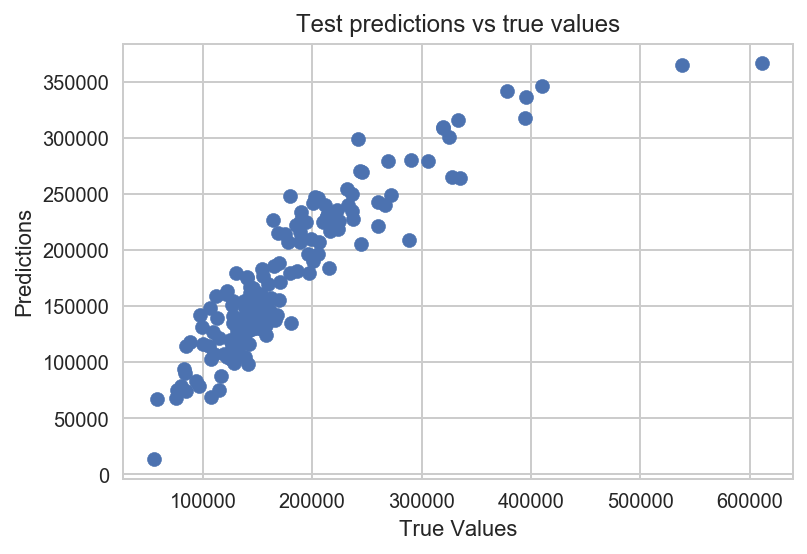

Test slr scores 0.804692388494
Train slr scores 0.78120894502

Linear regression coefficients [  2.38193266e+04   9.61888263e+03   5.73574079e+02   9.75717649e+03
   9.28320379e+03   1.19419649e+02   7.79282589e+00   1.96747407e+04
   1.24863655e+04   1.28548547e+04]

Cross-validated scores: [ 0.8392026   0.7788075   0.79602629  0.77443266  0.65459336]
Cross-Predicted R2: 0.768921715408


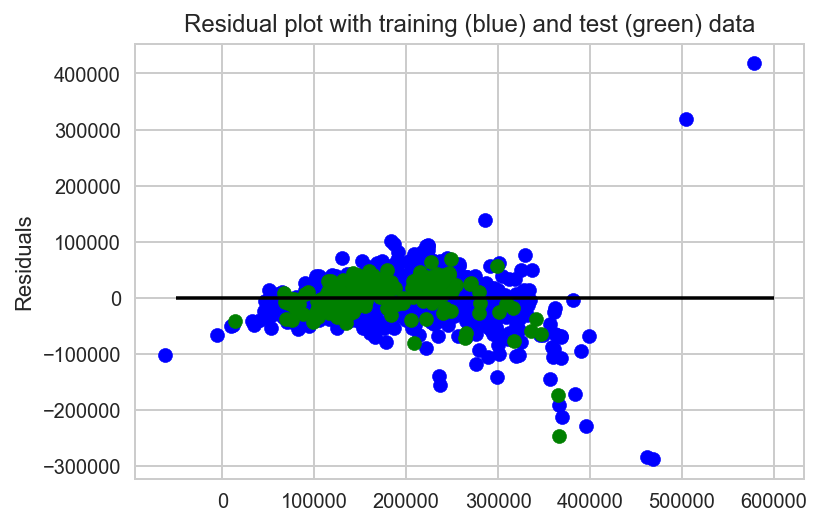

In [30]:
# Add 'renovate-able' correlations and test the results
# 1. OverallQual 2. ExterQual 3. KitchenQual 4. GarageFinish 5. FireplaceQu 6. BsmtFinType1 7. HeatingQC

# Only keep these 3
reno_features = ['OverallQual', 'ExterQual', 'KitchenQual']
predictions_test_reno, y_test_reno = run_linear_regression(house_features + reno_features)

### <font color='blue'>Looking at the average dollar improvement from adding the 'renovate-able' features it is clear we need to narrow our criteria for choosing suitable houses (see also plot below)

In [31]:
print("No Reno Mean", predictions_test.mean(), "With Reno Mean", predictions_test_reno.mean())
#for value1, value2 in zip(predictions_test, predictions_test_reno):
#    print("No renovation", value1, "Value added", value2-value1)

No Reno Mean 176042.257328 With Reno Mean 175472.957337


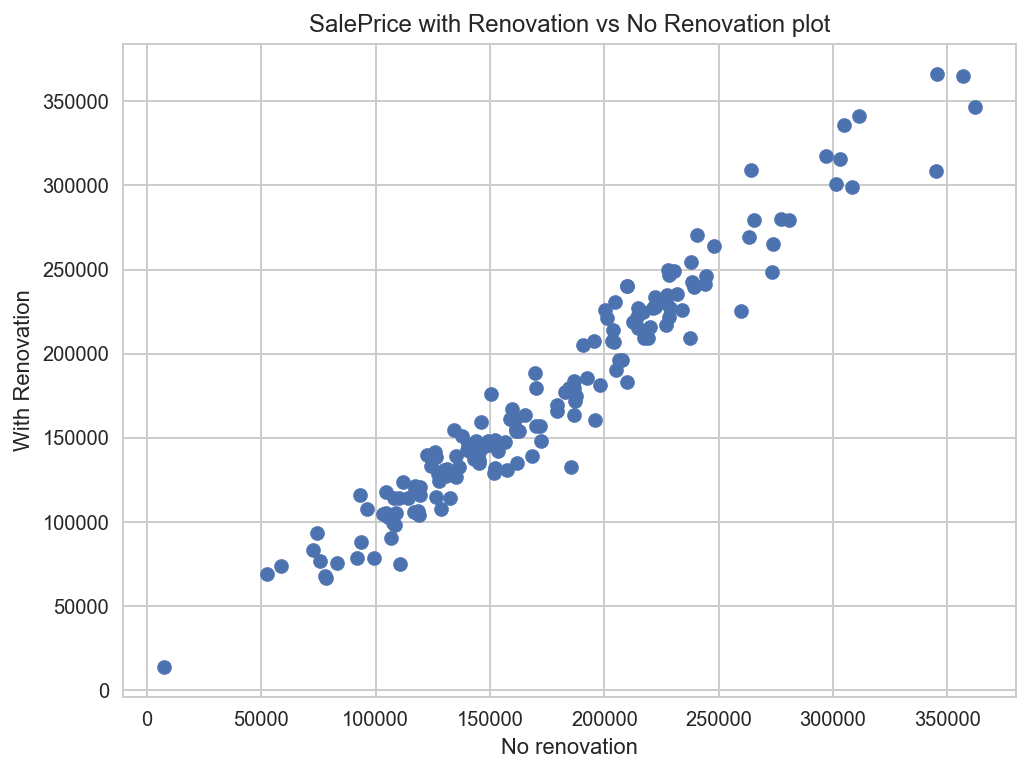

In [32]:
fig_size = [8, 6]
plt.rcParams["figure.figsize"] = fig_size

plt.scatter(predictions_test, predictions_test_reno)

plt.title("SalePrice with Renovation vs No Renovation plot")
plt.xlabel("No renovation")
plt.ylabel("With Renovation")

### <font color='blue'>There is a general trend that houses with a higher 'OverallQual' have a higher 'SalePrice' but we don't know how overall size may also be an influence

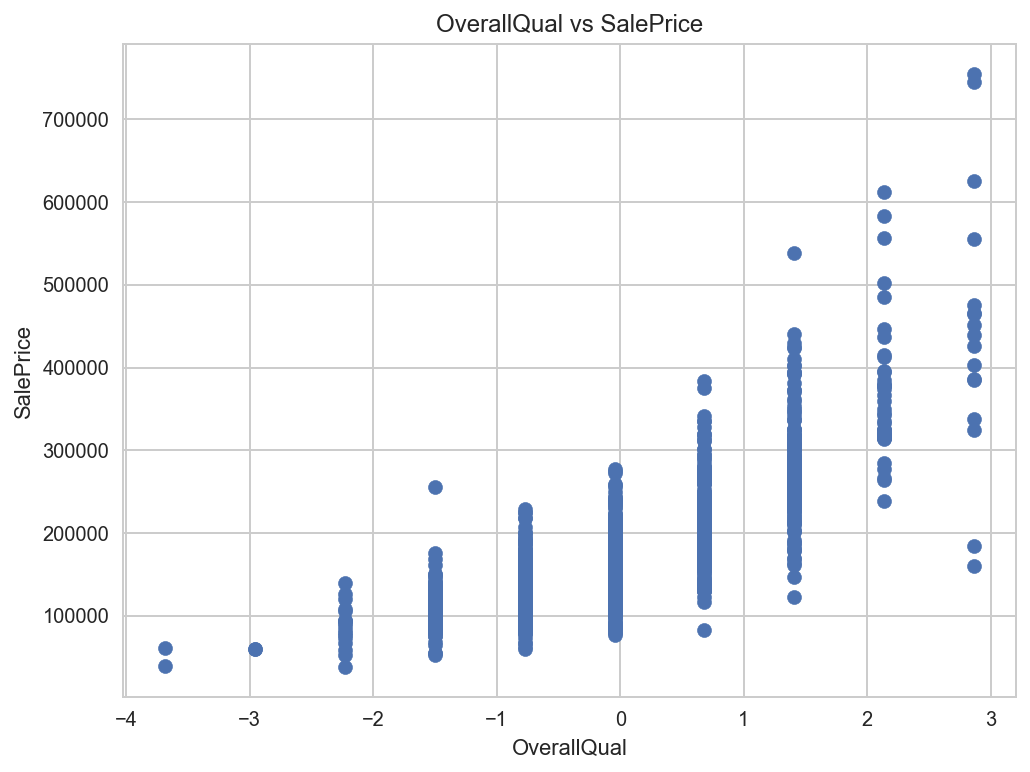

In [33]:
# Plot OverallQual vs SalePrice to look for patterns
plt.title("OverallQual vs SalePrice")
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")
plt.scatter(house_orig.OverallQual, house_orig.SalePrice)
plt.show()

### <font color='blue'>As square footage goes up so does the 'Sale Price'

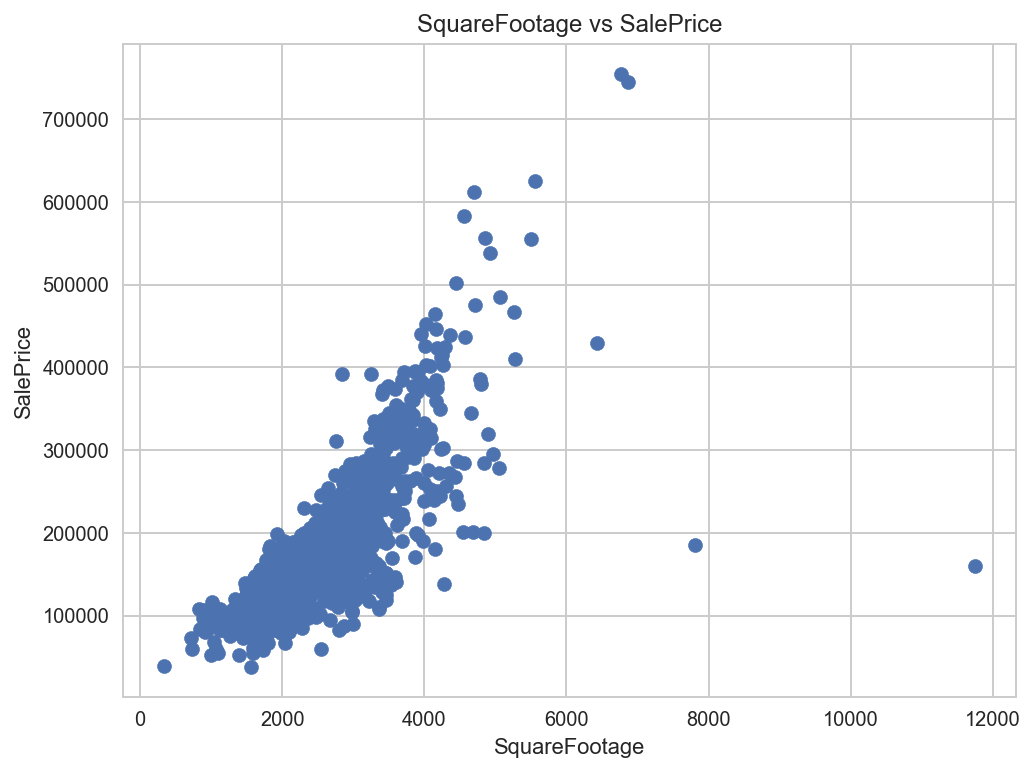

In [34]:
house_p2 = house_orig.copy()
house_p2['OverallQual'] = qual_area_orig['OverallQual']

# Create new square footage feature and plot it
square_footage = qual_area_orig['GrLivArea'] + qual_area_orig['TotalBsmtSF']
house_p2["SquareFootage"] = square_footage
plt.title("SquareFootage vs SalePrice")
plt.xlabel("SquareFootage")
plt.ylabel("SalePrice")
plt.scatter(house_p2.SquareFootage, house_p2.SalePrice)
plt.show()

### <font color='blue'>Plot square footage to see the distribution

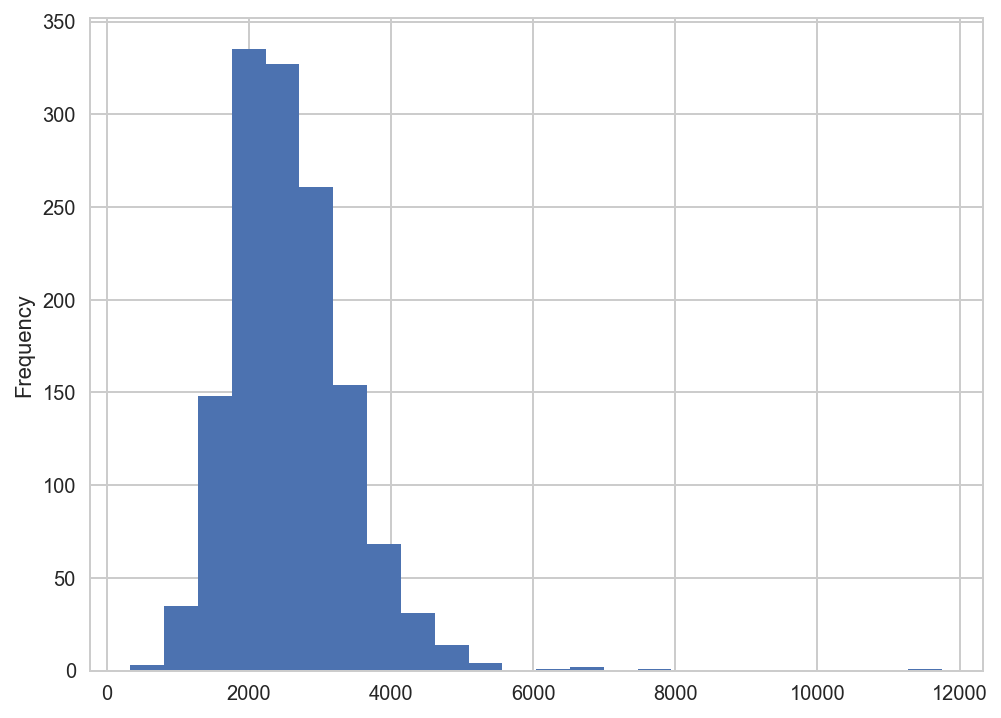

In [35]:
house_p2["SquareFootage"].plot.hist(bins=24)
plt.show()

### <font color='blue'>Compare 'like for like' houses by grouping them into similar sizes based on square footage

In [36]:
# Limit to where the main data lies
square_footage_min = 1000 #square_footage.min()
square_footage_max = 5000 #square_footage.max()

square_footage_spread = square_footage_max - square_footage_min
number_of_bins = 8
spread_per_bin = square_footage_spread / number_of_bins
print("Minimum square footage = ", square_footage_min, 
      "Maximum square footage =", square_footage_max,
      "Bin size =", spread_per_bin)

Minimum square footage =  1000 Maximum square footage = 5000 Bin size = 500.0


In [37]:
# setup data to use
house_p2 = house_p2[house_features + reno_features + ['SquareFootage', 'SalePrice']]
house_p2['ExterQual'] = house['ExterQual']
house_p2['KitchenQual'] = house['KitchenQual']
#print(house_p2.columns.values)

### <font color='blue'>When comparing 'like for like' houses a higher 'OverallQual' still tends towards a higher 'SalePrice' (see plot below)

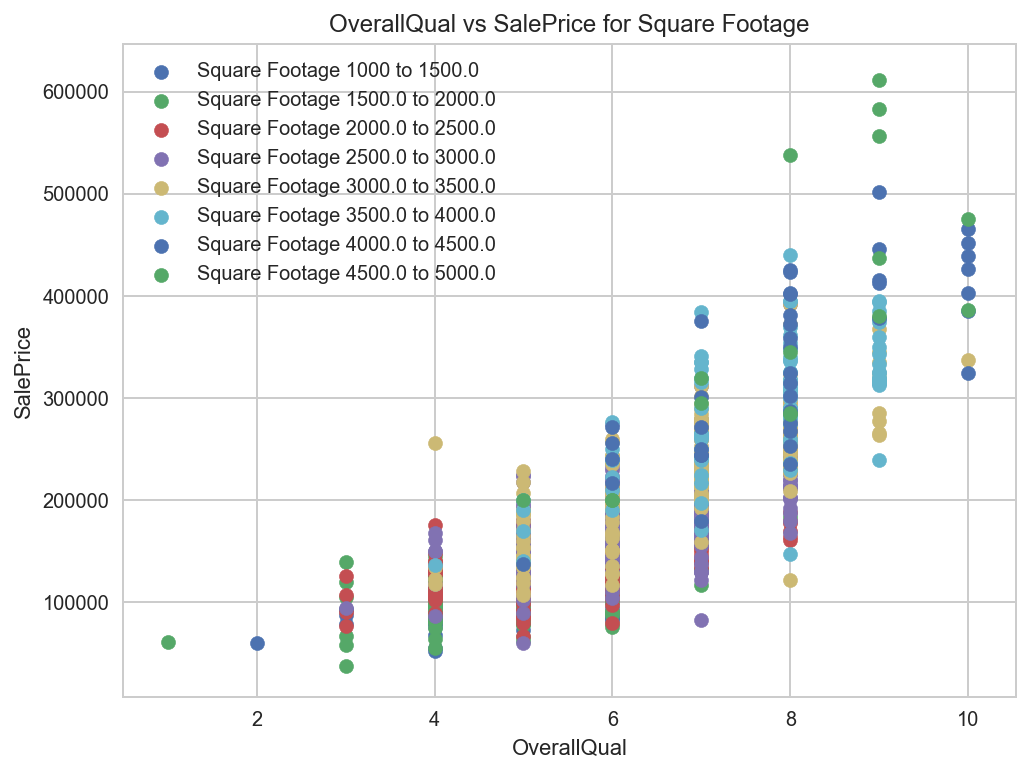

In [38]:
# distribute data into bins and then plot the bins
bins = []
legends = []
range_min = square_footage_min
range_max = range_min + spread_per_bin
for i in range(number_of_bins):
    mask = (house_p2['SquareFootage'] > range_min) & (house_p2['SquareFootage'] <= range_max)
    bins.append(house_p2[mask])
    #print(range_min, range_max)
    #print(bins[i].shape)

    title = 'Square Footage {} to {}'.format(range_min, range_max)
    legends.append(title)
    plt.scatter(bins[i].OverallQual, bins[i].SalePrice)
    #plt.show()

    range_min += spread_per_bin
    range_max += spread_per_bin

plt.title('OverallQual vs SalePrice for Square Footage')
plt.legend(legends)
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

fig_size = [12, 12]
plt.rcParams["figure.figsize"] = fig_size

plt.show()

### <font color='blue'>Create new dollars per square footage feature and plot it

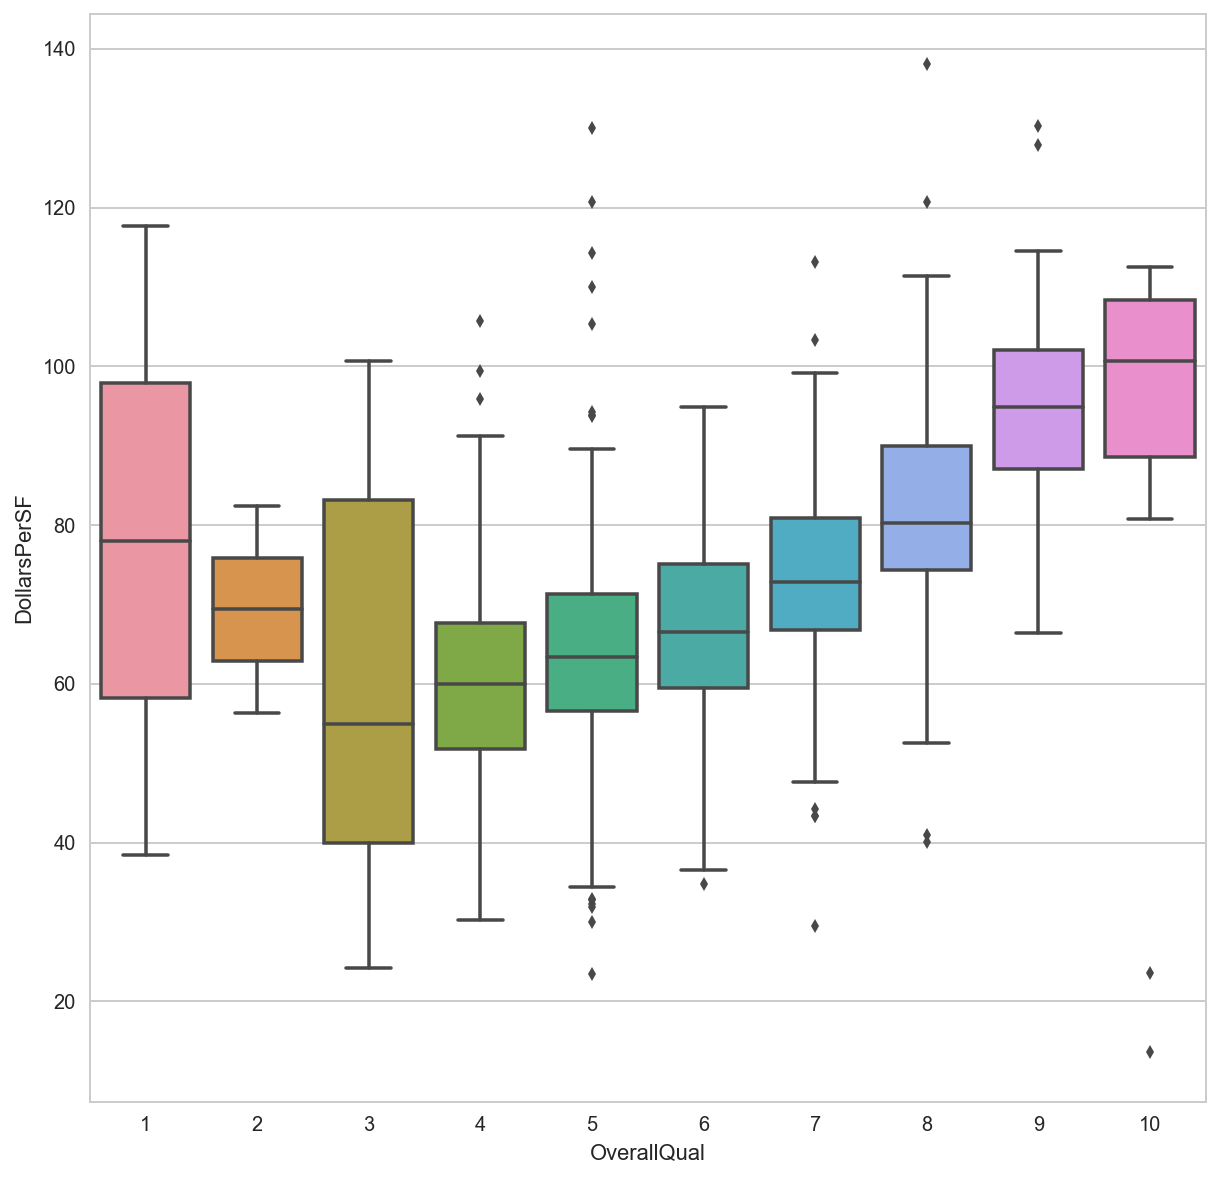

In [39]:
house_p2["DollarsPerSF"] = (house_p2['SalePrice'] / square_footage)

dpsf_oq = house_p2[['DollarsPerSF', 'OverallQual']]
plt.rc("figure", figsize=(10, 10))
sns.boxplot(x=dpsf_oq.OverallQual, y=dpsf_oq.DollarsPerSF, data=dpsf_oq)

### <font color='blue'>Targets
From the plot the best properties to target for profitable renovations are ones with median or lower square foot values that are rated as OverallQual of 3, 4, 5 and 6. Higher rated properties would not provide the same scope for adding value. Strangely properties that are rated 1 and 2 have higher values than expected and this requires further investiagtion.

### <font color='blue'>Target values for 'OverallQual' (similar calculations could be done for 'ExterQual' and 'KitchenQual')

In [40]:
#print(dpsf_oq.DollarsPerSF)
for i in range(3,7):
    mask = (dpsf_oq['OverallQual'] == i)
    dsf_details = house_p2[mask].DollarsPerSF.describe()
    #print(dsf_details) # 50% is the 6th element (index 5)
    print('Buy properties of "OverallQual" {} less than ${:,.2f} dollars per square feet'.format(i, dsf_details[5]))

Buy properties of "OverallQual" 3 less than $54.97 dollars per square feet
Buy properties of "OverallQual" 4 less than $59.98 dollars per square feet
Buy properties of "OverallQual" 5 less than $63.34 dollars per square feet
Buy properties of "OverallQual" 6 less than $66.55 dollars per square feet


# <font color='blue'>Part 3

## <font color='blue'>Setup the data

In [41]:
house_p3 = house_orig.copy()

# Convert SaleCondition categorical variable into dummy/indicator variables
SaleCondition = pd.get_dummies(house_p3.SaleCondition, prefix="SaleCondition")
#SaleCondition.drop(['SaleCondition_AdjLand'], axis=1, inplace=True)
house_p3.drop(['SaleCondition'], axis=1, inplace=True)

# drop 'SalePrice' column
house_p3.drop(['SalePrice'], axis=1, inplace=True)

# Convert categorical variable into dummy/indicator variables
house_p3 = pd.get_dummies(house_p3, drop_first=True)
house_p3['SaleCondition_Abnorml'] = SaleCondition['SaleCondition_Abnorml']
#house_p3[SaleCondition.columns.values] = SaleCondition
#print(house_p3.columns.values)

In [42]:
print('Actual "Abnorml" count', SaleCondition.SaleCondition_Abnorml.sum())
#print(SaleCondition.SaleCondition_AdjLand.sum())
#print(SaleCondition.SaleCondition_Alloca.sum())
#print(SaleCondition.SaleCondition_Family.sum())
#print(SaleCondition.SaleCondition_Normal.sum())
#print(SaleCondition.SaleCondition_Partial.sum())

Actual "Abnorml" count 92


## <font color='blue'>Features to select
The best results come from using all of the features and the second best option is to use the top 1, 2 or 3 features (see conclusions for more details).

In [43]:
corr = house_p3.corr()

# Look at the correlation values related to SaleCondition_Abnorml
#print('Top Absolute Correlations\n')
top_corr = corr.SaleCondition_Abnorml.abs().sort_values(ascending=False)#[1:4]
#print(top_corr)

# Create a list of potential predictor features
abnorml_predictor = []
for tac in top_corr.iteritems():
    abnorml_predictor.append(tac[0])
#print(abnorml_predictor)

## <font color='blue'>Setup y (target) and X features to use

In [44]:
y = SaleCondition['SaleCondition_Abnorml'].values
X = house_p3[abnorml_predictor]

## <font color='blue'>Do K nearest neighbours and cross validate

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Use 5 folds. How does the mean performace across folds compare to the baseline accuracy?
knn = KNeighborsClassifier(n_neighbors=5)
accs = cross_val_score(knn, X, y, cv=5)

# Calculate the accuracy on the test set and compare to baseline
baseline_acc = 1. - SaleCondition.SaleCondition_Abnorml.mean()
print(np.mean(accs), baseline_acc)

# Fit the KNN model
knn.fit(X, y)

0.928519102784 0.93357400722


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## <font color='blue'>Conclusions
Building a confusion matrix using all of the house features shows that only 6 true positive Abnorml values out of an actual 92 are predicted plus 3 false positives showing that this is a not a good model. Perhaps some experimental scaling of the data may be beneficial.

Strangely using only 1 to 3 of the top correlated features ['SaleType_Oth', 'SaleType_WD', 'Exterior1st_Stone'] shows 3 true positive Abnorml values out of an actual 92 are predicted plus 0 false positives. This sounds like a 'safe' model even if it is missing a lot of opportunities but looking at the features they look random rather than genuinely related and there would be a risk that any future properties identified may actually turn out to be false positives if this model were used.

In [46]:
# Create the confusion matrix for the classfier's performance
predicted = knn.predict(X)
conmat = np.array(confusion_matrix(y, predicted, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['is_Abnorml', 'is_other'],
                         columns=['predicted_Abnorml','predicted_other'])
confusion

,predicted_Abnorml,predicted_other
is_Abnorml,6,86
is_other,3,1290
